# IMDB Dataset

* A large dataset of movie review comments.

* Reviews are flagged as positive (pos:1) or negative (neg:0)

* Contains 25,000 training data and 25,000 test data

## Download IMDB

In [1]:
from torchtext import data; # Field/Label
from torchtext import datasets; # IMDB

TEXT = data.Field(sequential=True, fix_length=256, batch_first=True, lower=True, tokenize=lambda s:s)
LABEL = data.LabelField(sequential=False)

train_all, test_all = datasets.IMDB.splits(TEXT, LABEL)

aclImdb_v1.tar.gz:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:03<00:00, 21.2MB/s]


In [2]:
len(train_all)

25000

In [3]:
len(test_all)

25000

## Randomly extract the dataset

In [4]:
import random

In [5]:
train_size = 512
test_size = 64

In [6]:
pos_neg_dic = {
    'neg': 0,
    'pos': 1
}

In [7]:
train = random.sample([(t, pos_neg_dic[l]) for (t, l) in zip(train_all.text, train_all.label)], train_size)

In [8]:
test = random.sample([(t, pos_neg_dic[l]) for (t, l) in zip(test_all.text, test_all.label)], test_size)

## Save text, label pair to pd.DataFrame

In [9]:
import pandas as pd

train = pd.DataFrame(train, columns=['TEXT', 'LABEL'])
test = pd.DataFrame(test, columns=['TEXT', 'LABEL'])


In [10]:
train.head()

,TEXT,LABEL
0,(some possible spoilers)<br /><br /> i'm not t...,0
1,"this film was a waste of time, even rented on ...",0
2,"karen(bobbie phillips)mentions, after one of h...",0
3,impenetrable rubbish. this has to be one of th...,0
4,my grandmother took me and my sister out to se...,0


In [11]:
test.head()

,TEXT,LABEL
0,i very well remember the bad press this film g...,0
1,wow...<br /><br />reading through these commen...,0
2,this film would be particularly fun for anyone...,1
3,every saturday morning at 11 a.m. i watched su...,1
4,i happened into the den this morning during th...,1


In [12]:
train['LABEL'].value_counts(normalize=True)

0    0.529297
1    0.470703
Name: LABEL, dtype: float64

In [13]:
test['LABEL'].value_counts(normalize=True)

1    0.53125
0    0.46875
Name: LABEL, dtype: float64

## Tokenizer using BertTokenizerFast

In [14]:
!pip install transformers==3.1.0

     |████████████████████████████████| 890kB 13.5MB/s 
     |████████████████████████████████| 3.0MB 18.6MB/s 
     |████████████████████████████████| 890kB 52.5MB/s 
     |████████████████████████████████| 1.1MB 50.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=cdd3e75fbb622b52c58b4a190f8b0efa809c632c4fc31ea29138d3fd7faaca9f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [15]:
from transformers import BertTokenizerFast

In [16]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [17]:
encoded = tokenizer('I like an apple', 'I like apple watch')

In [18]:
tokenizer.decode(encoded['input_ids'])

'[CLS] i like an apple [SEP] i like apple watch [SEP]'

## Check Histogram of tokenized text for deciding maximum length for the input

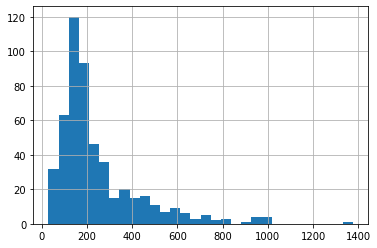

In [19]:
sequence_length = [len(str(w).split()) for w in train['TEXT']]
pd.Series(sequence_length).hist(bins=30)

In [20]:
max_sequence_length = 256

In [21]:
tokens_train = tokenizer.batch_encode_plus(
    train['TEXT'].tolist(),
    max_length = max_sequence_length,
    pad_to_max_length = True,
    truncation = True, 
    return_token_type_ids=False
)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [22]:
tokens_test = tokenizer.batch_encode_plus(
    test['TEXT'].tolist(),
    max_length = max_sequence_length,
    pad_to_max_length = True,
    truncation = True, 
    return_token_type_ids=False
)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [23]:
import torch

In [24]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train['LABEL'], dtype=torch.long)

In [25]:
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test['LABEL'], dtype=torch.long)

In [26]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [27]:
batch_size = 16

In [28]:
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [29]:
test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [30]:
from transformers import AutoModel

In [31]:
bert = AutoModel.from_pretrained('bert-base-uncased')

In [32]:
for param in bert.parameters():
  param.requires_grad = False

# Model definition

## Add up FCNN to BERT output layer

In [33]:
import torch.nn as nn

In [34]:
bert

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [35]:
class BERTBC(nn.Module):
  def __init__(self, bert):
    super().__init__()
    self.bert = bert
    self.dropout = nn.Dropout(p=0.1)
    self.relu = nn.ReLU()
    self.fc1 = nn.Linear(768, 256)
    self.fc2 = nn.Linear(256, 2)

  def forward(self, input_ids, attention_mask):
    _, cls_hs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    x = self.fc1(cls_hs)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc2(x)
    return x


In [36]:
net = BERTBC(bert)

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [38]:
device

device(type='cuda')

In [39]:
net = net.to(device)

In [40]:
input_ids, mask, labels = iter(train_dataloader).next()

In [41]:
type(input_ids)

torch.Tensor

In [42]:
input_ids.numpy()

array([[  101,  2445,  1996, ...,  1999,  1000,   102],
       [  101,  1996,  2143, ...,  2668,  1998,   102],
       [  101,  2957,  4487, ...,  7670,  1997,   102],
       ...,
       [  101, 12484, 18832, ...,     0,     0,     0],
       [  101,  2023,  2003, ...,     0,     0,     0],
       [  101,  2023,  2143, ...,     0,     0,     0]])

In [43]:
tokenizer.decode?

In [44]:
input_ids[0]

tensor([  101,  2445,  1996,  2111,  2920,  1010,  2009,  2003,  2524,  2000,
         2156,  2339,  2023,  3185,  2323,  2022,  2061, 18358,  2039,  1998,
        10634,  1012,  1996,  3213,  1010,  2585,  4829,  1010,  2626,  1996,
         6429,  4880,  2099,  2143,  1000,  1996, 12072,  1000,  2048,  2086,
         2101,  1010,  4869, 13545,  2050,  2018,  2074,  2180,  2019,  2914,
         2400,  2005,  1047,  7630,  2618,  1010,  1998,  6221, 14274,  2018,
         2074,  2589,  6581,  2147,  1999,  3152,  2066,  1000,  1047,  7630,
         2618,  1010,  1000,  1000,  2707,  1996,  4329,  2302,  2033,  1010,
         1000,  1998,  1000,  5163,  1005,  1055,  7348,  1012,  1000,  5436,
        14244,  1010,  1996,  3185,  2003,  1037,  4880,  2099,  6925,  1010,
         2007,  1037,  2235,  6080,  1997, 26352,  9709, 28616,  8873,  3215,
         4041,  1037,  2502,  2002,  2923,  1012,  2012,  1996,  2168,  2051,
         1996,  3185,  4122,  2000,  2022,  5099, 18312,  1010, 

In [45]:
pos_neg_dic.items()

dict_items([('neg', 0), ('pos', 1)])

In [46]:
tokenizer.decode(input_ids.numpy()[0])

'[CLS] given the people involved, it is hard to see why this movie should be so messed up and dull. the writer, david ward, wrote the amazing caper film " the sting " two years later, jane fonda had just won an academy award for klute, and donald sutherland had just done excellent work in films like " klute, " " start the revolution without me, " and " kelly\'s heroes. " plotwise, the movie is a caper tale, with a small gang of bumbling misfits planning a big heist. at the same time the movie wants to be hip satire, a series of comedy sketches of the type that the nbc television show " saturday night " would do so well two years later. the bad result is that the plot makes the comedy bits seem awkward and forced and the disconnected comedy bits destroy any kind of suspense that the heist might have. it is quite literally a movie that keeps smashing into itself, just as the cars in the cars in the demolition scenes run into each other. < br / > < br / > the only real interest for me was

## Blance the class weight percentge

In [47]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

class_wts = compute_class_weight("balanced", np.unique(train['LABEL']), train['LABEL'])
weights = torch.Tensor(class_wts)
weights = weights.to(device)


In [48]:
type(class_wts)

numpy.ndarray

In [49]:
import numpy as np
np.unique(train['LABEL'])

array([0, 1])

## Define hyper parameters

In [50]:
criterion = nn.CrossEntropyLoss(weight=weights)

In [51]:
from transformers import AdamW

learning_rate = 1e-3
optimizer = AdamW(net.parameters(), lr=learning_rate)

# Training Model

In [52]:
import time

def fit():
  print('\nTraining...')
  net.train()
  total_loss, total_accuracy = 0, 0
  total_preds = []
  t0 = time.time()
  elapsed = 0

  for step, batch in enumerate(train_dataloader):
    if step % 16 == 0 and not step == 0:
      elapsed = time.time() - t0
      print(f"Elapsed time:{elapsed:.3f}[sec.]")
      print('Batch {:>5} of {:>5}'.format(step, len(train_dataloader)))
    batch = [r.to(device) for r in batch]
    input_ids, mask, labels = batch

    net.zero_grad()
    preds = net(input_ids, mask)
    loss = criterion(preds, labels)
    total_loss += loss
    loss.backward()
    optimizer.step()

    torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
    preds = preds.detach().cpu().numpy()
    total_preds.append(preds)
  elapsed = time.time() - t0
  print(f"Elapsed time:{elapsed:.3f}[sec.]")
  avg_loss = total_loss / len(train_dataloader.dataset)
  total_preds = np.concatenate(total_preds, axis=0)
  return avg_loss, total_preds

In [53]:
def evaluate():
  print('\nEvaluating...')
  net.eval()
  total_loss, total_accuracy = 0, 0
  total_preds = []
  t0 = time.time()
  elapsed = 0

  for step, batch in enumerate(test_dataloader):
    if step % 16 == 0 and not step == 0:
      elapsed = time.time() - t0
      print(f"Elapsed time:{elapsed:.3f}[sec.]")
      print('Batch {:>5} of {:>5}'.format(step, len(test_dataloader)))
    batch = [r.to(device) for r in batch]
    input_ids, mask, labels = batch
    with torch.no_grad():
      preds = net(input_ids, mask)
      loss = criterion(preds, labels)
      total_loss += loss
      preds = preds.detach().cpu().numpy()
      total_preds.append(preds)
  elapsed = time.time() - t0
  print(f"Elapsed time:{elapsed:.3f}[sec.]")
  avg_loss = total_loss / len(test_dataloader.dataset)
  total_preds = np.concatenate(total_preds, axis=0)
  return avg_loss, total_preds

In [79]:
epochs = 20

best_valid_loss = float('inf')

train_losses = []
val_losses = []

for epoch in range(epochs):
  print(f'\n Epoch:{epoch+1}/{epochs}')
  train_loss, _ = fit()
  valid_loss, _ = evaluate()

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(net.state_dict(), 'saved_weights.pt')
  train_losses.append(train_loss)
  val_losses.append(valid_loss)
  print(f'\n Training Loss:{train_loss:.3f}, Validation Loss:{valid_loss:.3f}')




 Epoch:1/20

Training...
Elapsed time:4.005[sec.]
Batch    16 of    32
Elapsed time:7.992[sec.]

Evaluating...
Elapsed time:0.967[sec.]

 Training Loss:0.030, Validation Loss:0.031

 Epoch:2/20

Training...
Elapsed time:4.051[sec.]
Batch    16 of    32
Elapsed time:8.155[sec.]

Evaluating...
Elapsed time:0.998[sec.]

 Training Loss:0.028, Validation Loss:0.032

 Epoch:3/20

Training...
Elapsed time:4.177[sec.]
Batch    16 of    32
Elapsed time:8.392[sec.]

Evaluating...
Elapsed time:1.036[sec.]

 Training Loss:0.030, Validation Loss:0.033

 Epoch:4/20

Training...
Elapsed time:4.284[sec.]
Batch    16 of    32
Elapsed time:8.609[sec.]

Evaluating...
Elapsed time:1.062[sec.]

 Training Loss:0.029, Validation Loss:0.031

 Epoch:5/20

Training...
Elapsed time:4.378[sec.]
Batch    16 of    32
Elapsed time:8.772[sec.]

Evaluating...
Elapsed time:1.065[sec.]

 Training Loss:0.030, Validation Loss:0.031

 Epoch:6/20

Training...
Elapsed time:4.353[sec.]
Batch    16 of    32
Elapsed time:8.648

# Evaluate the Model

In [55]:
path = 'saved_weights.pt'

In [56]:
net.load_state_dict(torch.load(path))

<All keys matched successfully>

In [57]:
with torch.no_grad():
  preds = net(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [58]:
preds = np.array([np.argmax(r) for r in preds])

In [59]:
from sklearn.metrics import classification_report
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.89      0.57      0.69        30
           1       0.71      0.94      0.81        34

    accuracy                           0.77        64
   macro avg       0.80      0.75      0.75        64
weighted avg       0.80      0.77      0.76        64



# Prediction

In [60]:
infer_text = ["I hate Walking Dead Movie."]
ids_mask = tokenizer.batch_encode_plus(infer_text, True, True, True, 256)

In [61]:
ids_mask

{'input_ids': [[101, 1045, 5223, 3788, 2757, 3185, 1012, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1]]}

In [62]:
input_ids, attention_mask = ids_mask['input_ids'], ids_mask['attention_mask']

In [63]:
input_ids

[[101, 1045, 5223, 3788, 2757, 3185, 1012, 102]]

In [64]:
attention_mask

[[1, 1, 1, 1, 1, 1, 1, 1]]

In [65]:
device

device(type='cuda')

In [66]:
prediction = net(torch.tensor(input_ids).to(device), torch.tensor(attention_mask, dtype=torch.long).to(device))

In [67]:
prediction

tensor([[ 0.9022, -1.1052]], device='cuda:0', grad_fn=<AddmmBackward>)

In [68]:
torch.argmax(prediction).item()

0

# Final Project

Suppose we have four review comments below, and check if each comment is positive or negative using the trained model above. The answer should be in 'pos' or 'neg' format.

1. The spiderman was so cool. 

2. Blue crush is the most exciting movie I've ever watched.

3. I like the local boys movie.

4. I hate horror movies.

In [69]:
texts = ["The spiderman was so cool.",
          "Blue crush is the most exciting movie I've ever watched.",
         "I like the local boys movie.",
         "I hate horror movies."]

In [70]:
ids_mask = tokenizer.batch_encode_plus(texts, True, True, True, 256)

In [71]:
input_ids, attention_mask = ids_mask['input_ids'], ids_mask['attention_mask']

In [80]:
prediction = net(torch.tensor(input_ids).to(device), torch.tensor(attention_mask, dtype=torch.long).to(device))

In [81]:
prediction

tensor([[-0.2475,  0.3989],
        [ 0.1435, -0.0705],
        [-1.0360,  1.2168],
        [ 1.5428, -1.5161]], device='cuda:0', grad_fn=<AddmmBackward>)

In [82]:
prediction.max(dim=1)[1]

tensor([1, 0, 1, 0], device='cuda:0')

In [83]:
id_pos_neg = {
    0 : 'neg',
    1 : 'pos'
}

In [84]:
for i in prediction.max(dim=1)[1]:
  print(id_pos_neg[i.item()])

pos
neg
pos
neg
